# Predicting level of fatalities in political violence and protest events in India
The Armed Conflict Location & Event Data Project (ACLED) is a disaggregated conflict collection, analysis and crisis mapping project.ACLED collects the dates, actors, types of violence, locations, and fatalities of all reported political violence and protest events. Political violence and protest includes events that occur within civil wars and periods of instability, public protest and regime breakdown. Data collected from India during the period of 26-January-2016 to 26-January-2019
#### source: https://www.acleddata.com/data/
*Raleigh, Clionadh, Andrew Linke, Håvard Hegre and Joakim Karlsen. (2010).“Introducing ACLED-Armed Conflict Location and Event Data.” Journal of PeaceResearch 47(5) 651-660.*

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Although it is not advisable but to keep this notebook clean and short, supress warnings 
# comment this when you want to see warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

Display more columns in the data, we set it to 50.

In [4]:
pd.set_option('display.max_columns', 50)

### Loading Data into dataframe

In [5]:
# Loading protest and political violence data
data=pd.read_csv('ACLED_data_India_updated.csv')
# load codes description data
inter_codes=pd.read_csv('Inter_codes.csv')
geo_precision_codes=pd.read_csv('geo_precision_code.csv')
time_precision_codes=pd.read_csv('time_precision_code.csv')

After loading the data I first have to be know the basic structure of dataset to look for possible issues and cleaning up needed for it.

In [6]:
data.head()

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,actor1,assoc_actor_1,inter1,actor2,assoc_actor_2,inter2,interaction,region,country,admin1,admin2,admin3,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
0,3090605,356,IND46153,46153,16-Feb-19,2019,1,Battle-No change of territory,Military Forces of India (2014-),Police Forces of India (2014-) Border Security...,1,Military Forces of Pakistan (2018-),NaN,8,18,Southern Asia,India,Jammu and Kashmir,Rajouri,Naushera,Kalal,33.3418,74.3889,2,Chandigarh Tribune,Subnational,"On 16 Feb, Indian and Pakistani forces exchang...",0,1550588555,IND
1,3090606,356,IND46154,46154,16-Feb-19,2019,1,Remote violence,Unidentified Armed Group (India),NaN,3,Military Forces of India (2014-),NaN,1,13,Southern Asia,India,Jammu and Kashmir,Rajouri,Naushera,Jhangar Dharmsal,33.2705,74.0508,2,Chandigarh Tribune; Daily Excelsior,Subnational,"On 16 Feb, an Indian army officer was killed a...",1,1550588555,IND
2,3090607,356,IND46155,46155,16-Feb-19,2019,1,Riots/Protests,Rioters (India),NaN,5,NaN,NaN,0,50,Southern Asia,India,Jammu and Kashmir,Samba,Samba,Samba,32.5625,75.1199,2,Daily Excelsior,subnational,"On 16 Feb, people held demonstrations and burn...",0,1550588555,IND
3,3090608,356,IND46156,46156,16-Feb-19,2019,1,Riots/Protests,Rioters (India),NaN,5,NaN,NaN,0,50,Southern Asia,India,Jammu and Kashmir,Reasi,Reasi,Reasi,33.0792,74.8342,2,Daily Excelsior,subnational,"On 16 Feb, people held demonstrations and burn...",0,1550588555,IND
4,3090609,356,IND46157,46157,16-Feb-19,2019,1,Riots/Protests,Rioters (India),BJP: Bharatiya Janata Party,5,Police Forces of India (2014-),Civilians (India); TMC: Trinamool Congress Par...,1,15,Southern Asia,India,West Bengal,Birbhum,Labhpur,Labhpur,23.8160,87.7982,1,India Blooms News Service,National,"On February 16, locals attacked a TMC MLA and ...",0,1550588555,IND


In [7]:
inter_codes

,inter_code,description
0,0,No actor
1,1,Government and state security services
2,2,Rebel Groups
3,3,Political Militias
4,4,Identity Militias
5,5,Rioters
6,6,Protestors
7,7,Civilians
8,8,External/other forces


In [8]:
geo_precision_codes

,geo_precision_code,precision_level
0,1,highest (exact location)
1,2,intermediate (regional)
2,3,lowest (provincial)


In [9]:
time_precision_codes

,time_precision_code,precision_level
0,1,highest (day)
1,2,intermediate (week)
2,3,lowest (month)


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46135 entries, 0 to 46134
Data columns (total 30 columns):
data_id             46135 non-null int64
iso                 46135 non-null int64
event_id_cnty       46135 non-null object
event_id_no_cnty    46135 non-null int64
event_date          46135 non-null object
year                46135 non-null int64
time_precision      46135 non-null int64
event_type          46135 non-null object
actor1              46135 non-null object
assoc_actor_1       29511 non-null object
inter1              46135 non-null int64
actor2              12993 non-null object
assoc_actor_2       3627 non-null object
inter2              46135 non-null int64
interaction         46135 non-null int64
region              46135 non-null object
country             46135 non-null object
admin1              46135 non-null object
admin2              46124 non-null object
admin3              44509 non-null object
location            46135 non-null object
latitude          

Look at number of unique elements in each features

In [11]:
unique_count=pd.Series()
for column in data.columns:
    unique_count[column]=data[column].unique().size
unique_count

data_id             46135
iso                     1
event_id_cnty       46135
event_id_no_cnty    46135
event_date           1143
year                    4
time_precision          3
event_type              8
actor1                503
assoc_actor_1        1338
inter1                  8
actor2                257
assoc_actor_2         396
inter2                  9
interaction            40
region                  1
country                 2
admin1                 35
admin2                718
admin3               2865
location             6513
latitude             6652
longitude            6593
geo_precision           4
source                788
source_scale           19
notes               44657
fatalities             23
timestamp             162
iso3                    1
dtype: int64

## Cleaning up data
### Dropping features
First I drop columns with only one kind to data entry.

In [12]:
for column in unique_count.index:
    if unique_count[column]==1:
        data.drop(columns=column,inplace=True)

Second, I drop features with non-relavant information.

In [13]:
features_to_drop=['country','data_id','event_id_cnty','event_id_no_cnty','timestamp','year','interaction']
Data1=data.drop(columns=features_to_drop)

Next, I drop some features with information relavant but redundant. In training the prediction model I decided not to include these feature. 

In [14]:
Data1.drop(columns=['location','notes','latitude','longitude','admin2','admin3'],inplace=True)

### Changing date column to datetime format

In [15]:
Data1['event_date_formatted']=pd.to_datetime(Data1['event_date'])
Data1.drop(columns='event_date',inplace=True)

### Fixing for Null values
Columns and number of entries with NULL entries

In [16]:
Data1.isnull().sum()[Data1.isnull().sum()>0]

assoc_actor_1    16624
actor2           33142
assoc_actor_2    42508
source_scale        77
dtype: int64

First, I fix the NULL data in feature 'source_scale'.

The source_scale of the news is related to source of the news, for example newspaper 'The Times of India' is a National Newspaper. So, wherever the source_scale entry is null we look at the source then use the source_scale for that to fill in the missing value.

In [17]:
Source_missing_scale=Data1['source'][Data1.source_scale.isnull()].unique()
Source_missing_scale_filllist=pd.Series()
for source_name in Source_missing_scale:
    Source_missing_scale_filllist[source_name]=Data1[Data1['source']==source_name]['source_scale'].dropna().value_counts()
Source_missing_scale_filllist

Telegraph (India)                   National    208
Name: source_scale, dtype: int64
Sangai Express (India)             Subnational    126
National         1
Name: so...
Times of India                     National       759
Subnational      2
Name: so...
Asian News International           Regional         79
International     8
Nation...
Chandigarh Tribune                 Subnational    710
National       153
Name: so...
Indian Express                     National       1274
Subnational       1
region...
Pioneer (India)                    National       26
Subnational     1
Name: sour...
Hindustan Times (India)            National       273
Subnational      1
Name: so...
Pioneer (India); Times of India       National    1
Name: source_scale, dtype: int64
dtype: object

In [18]:
Data1.replace('regional','Regional',inplace=True) 
for source_item,source_scale_item in zip(Source_missing_scale_filllist.index,Source_missing_scale_filllist):
    Index_of_NaN=Data1.loc[Data1['source']==source_item][Data1.source_scale.isnull()].index
    Data1.loc[Index_of_NaN,'source_scale']=Source_missing_scale_filllist[source_item].idxmax()

Next, We will combine the actor1, actor2, associate actor1 and associate actor2 into one column and drop these columns. This will deal with null values in 'assoc_actor_1', 'actor2', 'assoc_actor_2'.

In [19]:
Actors=pd.Series(index=Data1.index)
Actor2_null_imask=Data1.actor2.notnull()
AssoActor1_null_imask=Data1.assoc_actor_1.notnull()
AssoActor2_null_imask=Data1.assoc_actor_2.notnull()
for idx in Data1.index:
    if Actor2_null_imask[idx] and AssoActor1_null_imask[idx] and AssoActor2_null_imask[idx]:
        Actors[idx]=[Data1.loc[idx,'actor1'],Data1.loc[idx,'actor2'],Data1.loc[idx,'assoc_actor_1'],Data1.loc[idx,'assoc_actor_2']]
    elif Actor2_null_imask[idx] and AssoActor1_null_imask[idx] and not AssoActor2_null_imask[idx]:
        Actors[idx]=[Data1.loc[idx,'actor1'],Data1.loc[idx,'actor2'],Data1.loc[idx,'assoc_actor_1']]
    elif Actor2_null_imask[idx] and not AssoActor1_null_imask[idx] and AssoActor2_null_imask[idx]:
        Actors[idx]=[Data1.loc[idx,'actor1'],Data1.loc[idx,'actor2'],Data1.loc[idx,'assoc_actor_2']]
    elif not Actor2_null_imask[idx] and AssoActor1_null_imask[idx] and AssoActor2_null_imask[idx]:
        Actors[idx]=[Data1.loc[idx,'actor1'],Data1.loc[idx,'assoc_actor_1'],Data1.loc[idx,'assoc_actor_2']]
    elif Actor2_null_imask[idx] and not AssoActor1_null_imask[idx] and not AssoActor2_null_imask[idx]:
        Actors[idx]=[Data1.loc[idx,'actor1'],Data1.loc[idx,'actor2']]
    elif not Actor2_null_imask[idx] and not AssoActor1_null_imask[idx] and AssoActor2_null_imask[idx]:
        Actors[idx]=[Data1.loc[idx,'actor1'],Data1.loc[idx,'assoc_actor_2']]
    elif not Actor2_null_imask[idx] and AssoActor1_null_imask[idx] and not AssoActor2_null_imask[idx]:
        Actors[idx]=[Data1.loc[idx,'actor1'],Data1.loc[idx,'assoc_actor_1']]
    else:
        Actors[idx]=Data1.loc[idx,'actor1']
Data1=Data1.join(pd.DataFrame(Actors,columns=['Actors']))
Data1.drop(columns=['actor1','actor2','assoc_actor_1', 'assoc_actor_2'],inplace=True)

### Creating new numerical features
To proceed with supervised learning algorithms I created numeric features from features with string entries.

Creating new feature of state label. Below is a table to show the state label and the state name.

In [20]:
States=pd.DataFrame(Data1.admin1.unique(),columns=['state'])
print(States)

                     state
0        Jammu and Kashmir
1              West Bengal
2              Maharashtra
3                    Assam
4                Meghalaya
5                   Odisha
6              Uttarakhand
7                   Punjab
8                Telangana
9         Himachal Pradesh
10           Uttar Pradesh
11            NCT of Delhi
12          Andhra Pradesh
13               Jharkhand
14                 Haryana
15              Tamil Nadu
16     Andaman and Nicobar
17                 Manipur
18                   Bihar
19          Madhya Pradesh
20            Chhattisgarh
21              Puducherry
22                  Kerala
23               Karnataka
24       Arunachal Pradesh
25                     Goa
26                 Mizoram
27                 Tripura
28              Chandigarh
29                Nagaland
30                 Gujarat
31               Rajasthan
32                  Sikkim
33           Daman and Diu
34  Dadra and Nagar Haveli


In [21]:
def State_label(state):
    for i in range(len(States)):
        if state==States.loc[i,'state']:
            return i
Data1['State_label']=Data1.admin1.apply(State_label)
Data1.drop(columns=['admin1'],inplace=True)

Creating new feature of Eventype label. Below is a table to show the Eventtype label and the Eventtype.

In [22]:
Events=pd.DataFrame(Data1.event_type.unique(),columns=['Event'])
print(Events)

                                 Event
0        Battle-No change of territory
1                      Remote violence
2                       Riots/Protests
3           Violence against civilians
4                Strategic development
5     Headquarters or base established
6    Non-violent transfer of territory
7  Battle-Government regains territory


In [23]:
def Event_label(event):
    for i in range(len(Events)):
        if event==Events.loc[i,'Event']:
            return i
Data1['Event_label']=Data1.event_type.apply(Event_label)
Data1.drop(columns=['event_type'],inplace=True)

Creating new feature of Month label where 1 is first month in dataset and goes as 1,2,.....37 

In [24]:
def month_of(date_formatted):
    return date_formatted.month+12*(date_formatted.year-2016)
Data1['month']=Data1.event_date_formatted.apply(month_of)
Data1.drop(columns=['event_date_formatted'],inplace=True)

Creating new feature of Number of actors 

In [25]:
def No_of_Actors(actors):
    if type(actors)==list:
        return len(actors)
    else:
        return 1
Data1['No_of_actors']=Data1['Actors'].apply(No_of_Actors)
Data1.drop(columns=['Actors'],inplace=True)

Creating a new feature that counts the number of sources

In [26]:
def Source_Split(datacut):
    SourceSplit=datacut.split("; ")
    return len(SourceSplit)
Data1['SourceCount']=Data1.source.apply(Source_Split)
Data1.drop(columns='source',inplace=True)

Convert source_scale into two type of columns which contains a source_scale numeric label and since each entry has at max two types of source_scale with make two columns. Below we show the label for source_scale and source_scale

In [27]:
def Source_scale_Split(datacut):
    SourceScaleSplit=datacut.split("-")
    return SourceScaleSplit
Data1['source_scale']=Data1.source_scale.apply(Source_scale_Split)
Source_Scale_columns=Data1.source_scale.apply(pd.Series).fillna(0)
Source_Scale_columns=Source_Scale_columns.rename(columns={0:"Source_scale1",1:"Source_scale2"})
SourceScaleList=Source_Scale_columns.Source_scale1.append(Source_Scale_columns.Source_scale2[Source_Scale_columns.Source_scale2.notnull()])
S_scale=pd.DataFrame(SourceScaleList.unique(),columns=['source_scale'])
print(S_scale)

    source_scale
0    Subnational
1    subnational
2       National
3       Regional
4          Other
5  International
6              0


In [28]:
def SourceScale_label(ss):
    for i in range(len(S_scale)):
        if ss==S_scale.loc[i,'source_scale']:
            return i+1
        if ss==0:
            return 0
Source_Scale_columns.Source_scale2=Source_Scale_columns.Source_scale2.apply(SourceScale_label)
Source_Scale_columns.Source_scale1=Source_Scale_columns.Source_scale1.apply(SourceScale_label)
Data1=pd.concat([Data1[:],Source_Scale_columns[:]],axis=1)
Data1.drop(columns=['source_scale'],inplace=True)

Next, we look at the feature that shows number of fatalities 

Text(0, 0.5, 'Frequency')

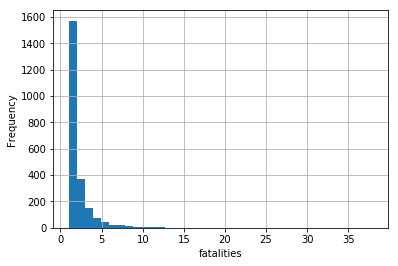

In [29]:
Hist=Data1.fatalities.hist(bins=max(Data1.fatalities),range=[1,max(Data1.fatalities)])
plt.xlabel('fatalities')
plt.ylabel('Frequency')

What we can see here that number of non-fatal events is significantly higher than fatal events. Also, events with >5 fatalities is even lower. So, we create new feature called 'Fatality_Label'.

0 for non-fatal event; 

1 for low fatality event; 

2 for high fatality event 

In [30]:
def fatal_label(fatal_count):
    if fatal_count==0:
        return 0
    elif fatal_count>5:
        return 2
    else:
        return 1
Data1['Fatality_Label']=Data1.fatalities.apply(fatal_label)
Data1.drop(columns=['fatalities'],inplace=True)

Count of events with different fatality label to give us an idea about the **level of fatalities** in all events.

In [31]:
Data1['Fatality_Label'].value_counts()

0    43839
1     2210
2       86
Name: Fatality_Label, dtype: int64

I further remove feature 'Source_scale2' after going over model evaluation and found that its removal made prediction better.

In [32]:
Data1.drop(columns=['Source_scale2'],inplace=True)

### Final DataFrame that we want to use for training

In [33]:
Data1.head()

,time_precision,inter1,inter2,geo_precision,State_label,Event_label,month,No_of_actors,SourceCount,Source_scale1,Fatality_Label
0,1,1,8,2,0,0,38,3,1,1,0
1,1,3,1,2,0,1,38,2,2,1,1
2,1,5,0,2,0,2,38,1,1,2,0
3,1,5,0,2,0,2,38,1,1,2,0
4,1,5,1,1,1,2,38,4,1,3,0


## Exploratory analysis

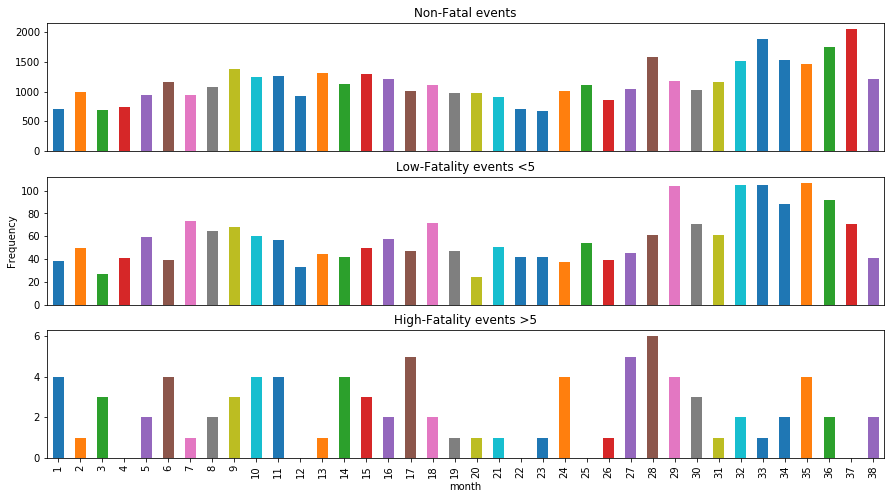

In [34]:
Month_hist=pd.crosstab(Data1.month,Data1.Fatality_Label)
fig, axs=plt.subplots(nrows=3, figsize=(15,8))
for i in range(3):
    Month_hist[i].plot.bar(ax=axs[i])
    if i==0:
        axs[i].set_title('Non-Fatal events') 
    elif i==1:
        axs[i].set_title('Low-Fatality events <5') 
        axs[i].set_ylabel('Frequency')
    else:
        axs[i].set_title('High-Fatality events >5') 
    if i!=2:
        axs[i].get_xaxis().set_ticks([])
        axs[i].set_xlabel(None)

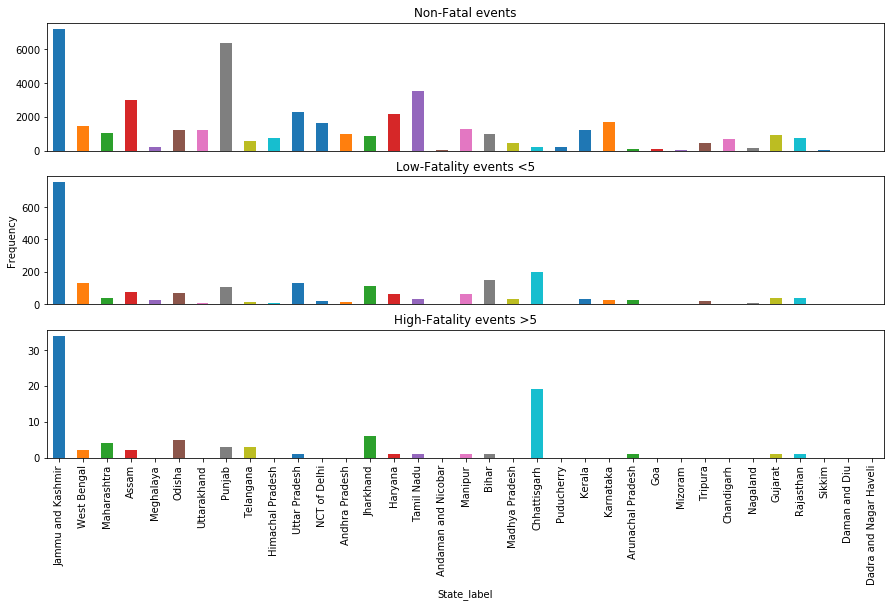

In [35]:
State_hist=pd.crosstab(Data1.State_label,Data1.Fatality_Label)
fig, axs=plt.subplots(nrows=3, figsize=(15,8))
for i in range(3):
    State_hist[i].plot.bar(ax=axs[i])
    if i==0:
        axs[i].set_title('Non-Fatal events') 
    elif i==1:
        axs[i].set_title('Low-Fatality events <5') 
        axs[i].set_ylabel('Frequency')
    else:
        axs[i].set_title('High-Fatality events >5') 
    if i!=2:
        axs[i].get_xaxis().set_ticks([])
        axs[i].set_xlabel(None)
    else:
        axs[i].set_xticklabels(list(States.state))

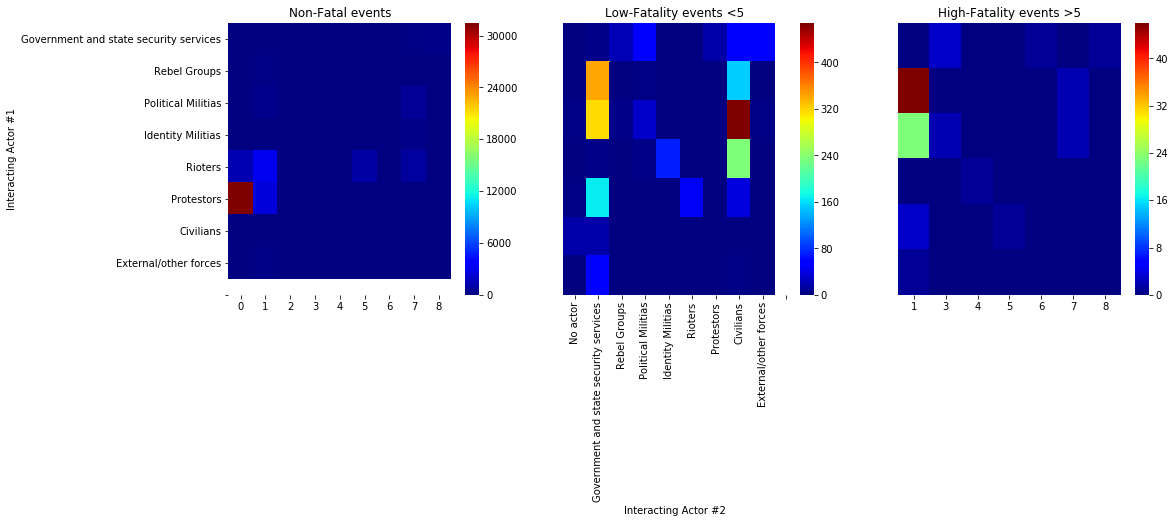

In [36]:
fig, axs=plt.subplots(ncols=3, figsize=(17,5))
for i in range(3):
    plt.subplot(131+i)
    Inter1_2=Data1.loc[Data1.Fatality_Label==i,['inter1','inter2']]
    sns.heatmap(pd.crosstab(Inter1_2.inter1,Inter1_2.inter2),cmap='jet')
    if i==0:
        plt.title('Non-Fatal events') 
        plt.ylabel('Interacting Actor #1')
        plt.xlabel('')
        plt.yticks(np.arange(0.5,9.5),list(inter_codes.description)[1:],rotation='horizontal')
        #plt.xticks(np.arange(9),list(inter_codes.description),rotation='vertical')
    elif i==1:
        plt.title('Low-Fatality events <5') 
        plt.xlabel('Interacting Actor #2')
        plt.ylabel('')
        plt.yticks([])
        plt.xticks(np.arange(0.5,10.5),list(inter_codes.description),rotation='vertical')
    else:
        plt.title('High-Fatality events >5')
        plt.xlabel('')
        plt.ylabel('')
        plt.yticks([])
        #plt.xticks(np.arange(9),list(inter_codes.description),rotation='vertical')

In [37]:
def Valid_range_check(mon):
        if mon>24 and mon<=32:
            return True
        else:
            return False
#splitting data into training, validation and test
#training: month 1 to 24 #validation: month 25 to 30 #test: month 33 to 37
Train_data_imask=Data1.month<=24
Valid_data_imask=Data1.month.apply(Valid_range_check)
Test_data_imask=Data1.month>32
print('Number of rows: Training data=',sum(Train_data_imask))
print('Number of rows: Validation data=',sum(Valid_data_imask))
print('Number of rows: Test data=',sum(Test_data_imask))
Train_data=Data1[Train_data_imask]
Valid_data=Data1[Valid_data_imask]
Test_data=Data1[Test_data_imask]

Number of rows: Training data= 25649
Number of rows: Validation data= 10064
Number of rows: Test data= 10422


In [38]:
X_train=Train_data.drop(['Fatality_Label'],axis=1)
Y_train=Train_data['Fatality_Label']
X_Valid=Valid_data.drop("Fatality_Label", axis=1)
Y_Valid=Valid_data['Fatality_Label']
X_test=Test_data.drop("Fatality_Label", axis=1)
Y_test=Test_data['Fatality_Label']

In [39]:
def SupervisedLearning(X_t,Y_t,X_V,Y_V):
    # Logistic Regression
    logreg=LogisticRegression(solver="newton-cg",multi_class='multinomial')
    logreg.fit(X_t,Y_t)
    Y_pred_log=logreg.predict(X_V)
    R2_log=round(logreg.score(X_t,Y_t)*100,2)
    RMSE_log=mean_squared_error(Y_V, Y_pred_log)
    Acc_log=accuracy_score(Y_V, Y_pred_log)
    Acc_fatal_log=accuracy_score(Y_V[Y_V>0],Y_pred_log[Y_V>0])
    # Decision Tree Classifier
    decision_tree=DecisionTreeClassifier()
    decision_tree.fit(X_t,Y_t)
    Y_pred_dt=decision_tree.predict(X_V)
    R2_decision_tree=round(decision_tree.score(X_t,Y_t)*100,2)
    RMSE_decision_tree=mean_squared_error(Y_V, Y_pred_dt)
    Acc_decision_tree=accuracy_score(Y_V, Y_pred_dt)
    Acc_fatal_decision_tree=accuracy_score(Y_V[Y_V>0],Y_pred_dt[Y_V>0])
    #Random Forest Classifier
    random_forest=RandomForestClassifier(n_estimators=100,random_state=123)
    random_forest.fit(X_t,Y_t)
    Y_pred_rf=random_forest.predict(X_V)
    R2_random_forest=round(random_forest.score(X_t,Y_t)*100,2)
    RMSE_random_forest=mean_squared_error(Y_V, Y_pred_rf)
    Acc_random_forest=accuracy_score(Y_V, Y_pred_rf)
    Acc_fatal_random_forest=accuracy_score(Y_V[Y_V>0],Y_pred_rf[Y_V>0])
    # Gaussian Naive Bayes 
    gaussian= GaussianNB()
    gaussian.fit(X_t,Y_t)
    Y_pred_gaus=gaussian.predict(X_V)
    R2_gaus=round(gaussian.score(X_t,Y_t)*100,2)
    RMSE_gaus=mean_squared_error(Y_V, Y_pred_gaus)
    Acc_gaus=accuracy_score(Y_V, Y_pred_gaus)
    Acc_fatal_gaus=accuracy_score(Y_V[Y_V>0],Y_pred_gaus[Y_V>0])
    # Linear Support Vector Machines
    linear_SVC=LinearSVC(max_iter=100,random_state=123)
    linear_SVC.fit(X_t,Y_t)
    Y_pred_svc=linear_SVC.predict(X_V)
    R2_linear_svc=round(linear_SVC.score(X_t,Y_t)*100,2)
    RMSE_linear_svc=mean_squared_error(Y_V, Y_pred_svc)
    Acc_linear_svc=accuracy_score(Y_V, Y_pred_svc)
    Acc_fatal_linear_svc=accuracy_score(Y_V[Y_V>0],Y_pred_svc[Y_V>0])
    # K-nearest neighbor
    Knn=KNeighborsClassifier(n_neighbors=4)
    Knn.fit(X_t,Y_t)
    Y_pred_knn=Knn.predict(X_V)
    R2_knn=round(Knn.score(X_t,Y_t)*100,2)
    RMSE_knn=mean_squared_error(Y_V, Y_pred_knn)
    Acc_knn=accuracy_score(Y_V, Y_pred_knn)
    Acc_fatal_knn=accuracy_score(Y_V[Y_V>0],Y_pred_knn[Y_V>0])
    # Stochastic Gradient descent 
    SGD= SGDClassifier(random_state=123)
    SGD.fit(X_t,Y_t)
    Y_pred_sdg=SGD.predict(X_V)
    R2_sdg=round(SGD.score(X_t,Y_t)*100,2)
    RMSE_sdg=mean_squared_error(Y_V, Y_pred_sdg)
    Acc_sdg=accuracy_score(Y_V, Y_pred_sdg)
    Acc_fatal_sdg=accuracy_score(Y_V[Y_V>0],Y_pred_sdg[Y_V>0])
    # AdaBoostClassifier uses adaptive Boosting classification 
    ABC=AdaBoostClassifier(base_estimator=RandomForestClassifier(n_estimators=10),learning_rate=0.1,random_state=123)
    ABC.fit(X_t,Y_t)
    Y_pred_ABC=ABC.predict(X_V)
    R2_ABC=round(ABC.score(X_t,Y_t)*100,2)
    RMSE_ABC=mean_squared_error(Y_V, Y_pred_ABC)
    Acc_ABC=accuracy_score(Y_V, Y_pred_ABC)
    Acc_fatal_ABC=accuracy_score(Y_V[Y_V>0],Y_pred_ABC[Y_V>0])
    XGBmodel=XGBClassifier(seed=1,learning_rate=0.1,n_estimators=100)
    XGBmodel.fit(X_t,Y_t)
    Y_pred_XGB=XGBmodel.predict(X_V)
    R2_XGBmodel=round(XGBmodel.score(X_t,Y_t)*100,2)
    RMSE_XGBmodel=mean_squared_error(Y_V, Y_pred_XGB)
    Acc_XGBmodel=accuracy_score(Y_V, Y_pred_XGB)
    Acc_fatal_XGBmodel=accuracy_score(Y_V[Y_V>0],Y_pred_XGB[Y_V>0])
    # Model Validation score dataframe
    Model_Validation = pd.DataFrame({
        'Model': ['Logistic Regression','DecisionTreeClassifier','RandomForestClassifier',
                  'Gaussian Naive Bayes','Linear support vector machines','K-nearest neighbor',
                  'Stochastic Gradient descent','AdaBoost','XG Boost'],
        'R2 Score': [R2_log,R2_decision_tree,R2_random_forest,R2_gaus,R2_linear_svc,R2_knn,R2_sdg,R2_ABC,R2_XGBmodel],
        'RMSE score':[RMSE_log,RMSE_decision_tree,RMSE_random_forest,RMSE_gaus,RMSE_linear_svc,RMSE_knn,
                      RMSE_sdg,RMSE_ABC,RMSE_XGBmodel],
        'Accuracy score':[Acc_log,Acc_decision_tree,Acc_random_forest,Acc_gaus,Acc_linear_svc,Acc_knn,
                          Acc_sdg,Acc_ABC,Acc_XGBmodel],
        'Accuracy score (Fatal events)':[Acc_fatal_log,Acc_fatal_decision_tree,Acc_fatal_random_forest,Acc_fatal_gaus,
                                         Acc_fatal_linear_svc,Acc_fatal_knn,Acc_fatal_sdg,Acc_fatal_ABC,Acc_fatal_XGBmodel]})
    return Model_Validation

In [40]:
ValidScore=SupervisedLearning(X_train,Y_train,X_Valid,Y_Valid)
ValidScore.sort_values(by='Accuracy score (Fatal events)', ascending=False)

,Model,R2 Score,RMSE score,Accuracy score,Accuracy score (Fatal events)
1,DecisionTreeClassifier,98.86,0.067568,0.934221,0.519573
2,RandomForestClassifier,98.86,0.066176,0.938295,0.503559
7,AdaBoost,98.86,0.067071,0.937699,0.492883
3,Gaussian Naive Bayes,90.00,0.308227,0.866157,0.469751
8,XG Boost,96.51,0.053955,0.948132,0.329181
5,K-nearest neighbor,96.88,0.052365,0.949424,0.295374
0,Logistic Regression,95.00,0.066276,0.937897,0.115658
4,Linear support vector machines,95.06,0.064984,0.939189,0.074733
6,Stochastic Gradient descent,95.21,0.059718,0.945350,0.028470


In [41]:
# Best RMSE and Accuracy score for Random Forest Classifier
# We use that for fitting test data
random_forest=RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train,Y_train)
Y_testpred=random_forest.predict(X_test)
RMSE_test=mean_squared_error(Y_test, Y_testpred)
Acc_test=accuracy_score(Y_test, Y_testpred)
Acc_fatal_test=accuracy_score(Y_test[Y_test>0],Y_testpred[Y_test>0])
print('Random Forest Classifier based prediction for the month of October 2018 -Feb 2019')
print('Root mean square error',RMSE_test)
print('Accuracy',Acc_test)
print('Accuracy (Fatal events)',Acc_fatal_test)

Random Forest Classifier based prediction for the month of October 2018 -Feb 2019
Root mean square error 0.05094991364421416
Accuracy 0.9490500863557858
Accuracy (Fatal events) 0.5087378640776699


In [42]:
# Eventhough the accuracy is high but the the accuracy for events that actually lead to fatalities have bad accuracy
# We want to fix that and deal with the unbalanced dataset for the three classes we are trying to predict
# Technique#1. Up-sample Minority Class
from sklearn.utils import resample
df_fatal0=Train_data[Train_data.Fatality_Label==0]
df_fatal1=Train_data[Train_data.Fatality_Label==1]
df_fatal2=Train_data[Train_data.Fatality_Label==2]

In [43]:
# Upsample Class Fatality_Label=1
df_fatal1_upsampled = resample(df_fatal1, 
                                 replace=True,     # sample with replacement
                                 n_samples=Data1['Fatality_Label'].value_counts()[0],# to match Class Fatality_Label=0
                                 random_state=123) # reproducible results
# Upsample Class Fatality_Label=2
df_fatal2_upsampled = resample(df_fatal2, 
                                 replace=True,     # sample with replacement
                                 n_samples=Data1['Fatality_Label'].value_counts()[0],# to match Class Fatality_Label=0
                                 random_state=123) # reproducible results
# Combine majority class with upsampled minority class
Train_data_upsampled = pd.concat([df_fatal0, df_fatal1_upsampled,df_fatal2_upsampled])
X_train_upsampled=Train_data_upsampled.drop(['Fatality_Label'],axis=1)
Y_train_upsampled=Train_data_upsampled['Fatality_Label']

In [44]:
ValidScore=SupervisedLearning(X_train_upsampled,Y_train_upsampled,X_Valid,Y_Valid)
ValidScore.sort_values(by='Accuracy score (Fatal events)', ascending=False)

,Model,R2 Score,RMSE score,Accuracy score,Accuracy score (Fatal events)
6,Stochastic Gradient descent,42.24,0.919913,0.080087,0.955516
8,XG Boost,86.83,0.161566,0.890302,0.786477
0,Logistic Regression,71.33,0.196045,0.848072,0.713523
2,RandomForestClassifier,97.86,0.081280,0.929452,0.610320
5,K-nearest neighbor,96.71,0.097178,0.917727,0.596085
4,Linear support vector machines,68.09,0.792925,0.730823,0.492883
1,DecisionTreeClassifier,97.86,0.092110,0.924583,0.476868
7,AdaBoost,97.82,0.082373,0.931936,0.475089
3,Gaussian Naive Bayes,59.00,0.716117,0.769475,0.085409


In [45]:
# Next best accuracy score is using XGBoost Classifier the overall accuracy score is 89%
# and for fatal event is very good 80% so we use that to predict test data
XGBmodel=XGBClassifier(seed=1,learning_rate=0.1,n_estimators=100)
XGBmodel.fit(X_train_upsampled,Y_train_upsampled)
Y_pred_test_upsampled1=XGBmodel.predict(X_test)
RMSE_test_upsampled1=mean_squared_error(Y_test, Y_pred_test_upsampled1)
Acc_test_upsampled1=accuracy_score(Y_test, Y_pred_test_upsampled1)
Acc_fatal_test_upsampled1=accuracy_score(Y_test[Y_test>0],Y_pred_test_upsampled1[Y_test>0])
print(' XGBoost Classifier after UpSampling based prediction for the month of October 2018 -Feb 2019')
print('Root mean square error',RMSE_test_upsampled1)
print('Accuracy',Acc_test_upsampled1)
print('Accuracy (Fatal events)',Acc_fatal_test_upsampled1)

 XGBoost Classifier after UpSampling based prediction for the month of October 2018 -Feb 2019
Root mean square error 0.1457493763193245
Accuracy 0.890520053732489
Accuracy (Fatal events) 0.8


In [46]:
# Next best accuracy score is using Logistic Regression the overall accuracy score is 84%
# and for fatal event is very good 71% so we use that to predict test data
logreg=LogisticRegression(solver="newton-cg",multi_class='multinomial')
logreg.fit(X_train_upsampled,Y_train_upsampled)
Y_pred_test_upsampled2=logreg.predict(X_test)
RMSE_test_upsampled2=mean_squared_error(Y_test, Y_pred_test_upsampled2)
Acc_test_upsampled2=accuracy_score(Y_test, Y_pred_test_upsampled2)
Acc_fatal_test_upsampled2=accuracy_score(Y_test[Y_test>0],Y_pred_test_upsampled2[Y_test>0])
print(' Logistic Regression Classifier after UpSampling based prediction for the month of October 2018 -Feb 2019')
print('Root mean square error',RMSE_test_upsampled2)
print('Accuracy',Acc_test_upsampled2)
print('Accuracy (Fatal events)',Acc_fatal_test_upsampled2)

 Logistic Regression Classifier after UpSampling based prediction for the month of October 2018 -Feb 2019
Root mean square error 0.18700825177509114
Accuracy 0.8331414315870275
Accuracy (Fatal events) 0.7533980582524272


In [47]:
# Technique#2.penalized learning algorithms that increase the cost of classification mistakes on the minority class
from sklearn.svm import SVC
SVC_penalized = SVC(kernel='linear',class_weight='balanced',probability=True)
SVC_penalized.fit(X_train,Y_train)
Y_pred_SVC_penalized=SVC_penalized.predict(X_Valid)
R2_SVC_penalized=round(SVC_penalized.score(X_train,Y_train)*100,2)
RMSE_SVC_penalized=mean_squared_error(Y_Valid, Y_pred_SVC_penalized)
Acc_SVC_penalized=accuracy_score(Y_Valid, Y_pred_SVC_penalized)
Acc_fatal_SVC_penalized=accuracy_score(Y_Valid[Y_Valid>0],Y_pred_SVC_penalized[Y_Valid>0])

In [48]:
logreg_penalized=LogisticRegression(solver="newton-cg",multi_class='multinomial',class_weight='balanced')
logreg_penalized.fit(X_train,Y_train)
Y_pred_log_penalized=logreg_penalized.predict(X_Valid)
R2_log_penalized=round(logreg_penalized.score(X_train,Y_train)*100,2)
RMSE_log_penalized=mean_squared_error(Y_Valid, Y_pred_log_penalized)
Acc_log_penalized=accuracy_score(Y_Valid, Y_pred_log_penalized)
Acc_fatal_log_penalized=accuracy_score(Y_Valid[Y_Valid>0],Y_pred_log_penalized[Y_Valid>0])

In [49]:
PenalizedValidation = pd.DataFrame({
        'Model': ['Penalized Support Vector Machine','Penalized Logistic Regression'],
        'R2 Score': [R2_SVC_penalized,R2_log_penalized],
        'RMSE score':[RMSE_SVC_penalized,RMSE_log_penalized],
        'Accuracy score':[Acc_SVC_penalized,Acc_log_penalized],
        'Accuracy score (Fatal events)':[Acc_fatal_SVC_penalized,Acc_fatal_log_penalized]})
PenalizedValidation.sort_values(by='Accuracy score (Fatal events)', ascending=False)

,Model,R2 Score,RMSE score,Accuracy score,Accuracy score (Fatal events)
1,Penalized Logistic Regression,88.62,0.188096,0.859897,0.677936
0,Penalized Support Vector Machine,88.20,0.220787,0.851053,0.645907


In [50]:
# Use penalized logistic regression to predict on test data
Y_pred_test_penalized=logreg_penalized.predict(X_test)
RMSE_test_penalized=mean_squared_error(Y_test, Y_pred_test_penalized)
Acc_test_penalized=accuracy_score(Y_test, Y_pred_test_penalized)
Acc_fatal_test_penalized=accuracy_score(Y_test[Y_test>0],Y_pred_test_penalized[Y_test>0])
print(' Logistic Regression Classifier with penalization based prediction for the month of October 2018 -Feb 2019')
print('Root mean square error',RMSE_test_penalized)
print('Accuracy',Acc_test_penalized)
print('Accuracy (Fatal events)',Acc_fatal_test_penalized)

 Logistic Regression Classifier with penalization based prediction for the month of October 2018 -Feb 2019
Root mean square error 0.17549414699673768
Accuracy 0.8463826520821339
Accuracy (Fatal events) 0.7300970873786408


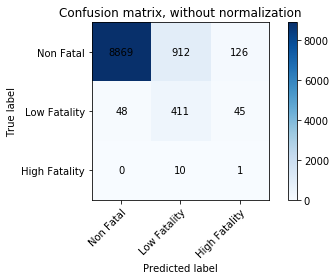

In [51]:
class_names=["Non Fatal","Low Fatality","High Fatality"]
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,normalize=False,cmap=plt.cm.Blues):
    if normalize:
        title = 'Normalized confusion matrix'
    else:
        title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,ylabel='True label',xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j],ha="center", va="center")
    fig.tight_layout()
    return ax
# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, Y_pred_test_upsampled1, classes=class_names)
plt.show()

In [52]:
# Accuracy of Eventype-wise prediction
Eventype_Acc=pd.Series(index=Events.Event)
Eventype_Fatal_Acc=pd.Series(index=Events.Event)
for i in range(len(Events)):
    Event_imask=X_test.Event_label==i
    Y_test_imask=Y_test[Event_imask]
    Y_pred_imask=Y_pred_test_upsampled1[Event_imask]
    Eventype_Acc[Events.Event[i]]=accuracy_score(Y_test_imask,Y_pred_imask)
    Eventype_Fatal_Acc[Events.Event[i]]=accuracy_score(Y_test_imask[Y_test_imask>0],Y_pred_imask[Y_test_imask>0])
Eventype_Acc.fillna(0,inplace=True)
Eventype_Fatal_Acc.fillna(0,inplace=True)

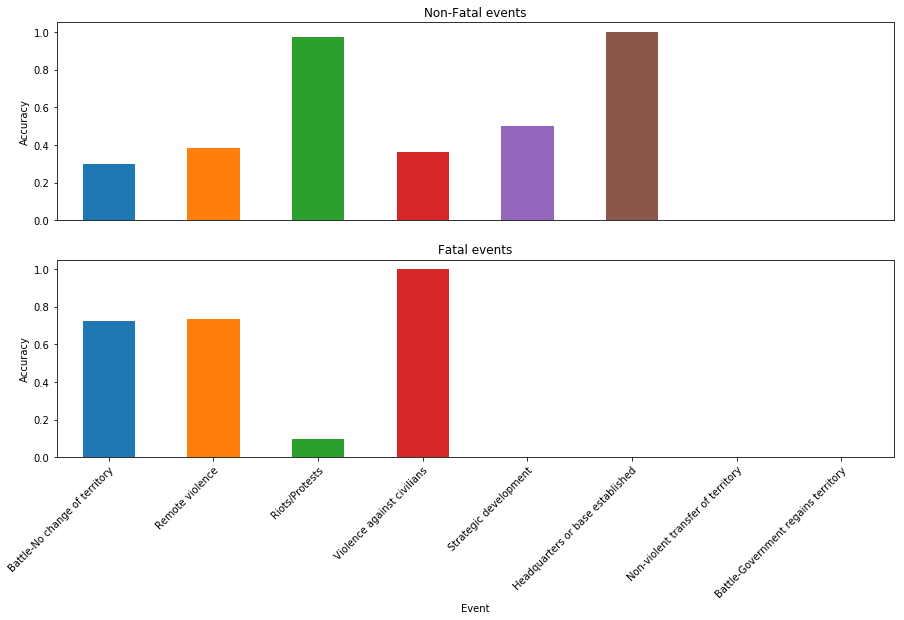

In [53]:
fig, axs=plt.subplots(nrows=2, figsize=(15,8))
for i in range(2):
    if i==0:
        Eventype_Acc.plot.bar(ax=axs[i])
        axs[i].get_xaxis().set_ticks([])
        axs[i].set_title('Non-Fatal events') 
        axs[i].set_ylabel('Accuracy')
        axs[i].set_xlabel(None)
    elif i==1:
        Eventype_Fatal_Acc.plot.bar(ax=axs[i])
        axs[i].set_title('Fatal events') 
        axs[i].set_ylabel('Accuracy')
        axs[i].set_xticklabels(list(Events.Event))
        plt.setp(axs[i].get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")